In [14]:
pip install astropy

  Using cached astropy-7.1.1-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pyerfa-2.0.1.5-cp39-abi3-win_amd64.whl.metadata (5.9 kB)
  Using cached astropy_iers_data-0.2025.11.3.0.38.37-py3-none-any.whl.metadata (3.4 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-win_amd64.whl.metadata (2.4 kB)
Using cached astropy-7.1.1-cp312-cp312-win_amd64.whl (6.3 MB)
Using cached astropy_iers_data-0.2025.11.3.0.38.37-py3-none-any.whl (2.0 MB)
Using cached pyerfa-2.0.1.5-cp39-abi3-win_amd64.whl (349 kB)
Using cached pyyaml-6.0.3-cp312-cp312-win_amd64.whl (154 kB)

   ---------------------------------------- 0/4 [PyYAML]
   ---------- ----------------------------- 1/4 [pyerfa]
   -------------------- ------------------- 2/4 [astropy-iers-data]
   ------------------------------ --------- 3/4 [astropy]
   ------------------------------ --------- 3/4 [astropy]
   ------------------------------ --------- 3/4 [astropy]
   ------------------------------ --------- 3/4 [astropy]
   -----------------

In [16]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib as mp
# import gaia_tools as gt
import scipy
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.coordinates import SkyCoord
import math
import h5py
# import healpy as hp
import pykdgrav3_utils
from pykdgrav3_utils import units
u = units.units(1, 600., verbose=True)

sys.path.append('C:/gaiaenv/New Py/My_thesis/Modules')
from mock_wake import generate_mock_wake
from rotation_funcs import rotate, angle_finder, rz, ry, rx

dMsolUnit = 1.000000e+00
dKpcUnit = 6.000000e+02
dGasConst =  1150890.1952769116
dErgPerGmUnit =  71.68174956254887
dGmPerCcUnit =  3.1333829769061664e-40
dSecUnit =  2.1867420491060357e+23
dKmPerSecUnit =  8.466507518602276e-05
dComovingGmPerCcUnit =  3.1333829769061664e-40


In [17]:
file = 'C:/Data/Praktika_data/dm_sim.00001.0'

def load_snap_file(path, part_type='PartType1', is_print = False):

    snap_file = h5py.File(path, 'r')
    part_data = snap_file[part_type]

    if(is_print):
        print(f'Loading snapshot: {path.split("/")[-1]}')
        print(f'Selected species: {part_type}')
        print(f'Snap file keys: {snap_file.keys()}')
        print(f'Part type keys: {part_data.keys()}')

    return part_data

In [18]:
## Find LMC velocity when it is at 70 kpc distance. Also find its current position.

orbitfile = 'C:/Data/Praktika_data/trajlmc.txt'
orbit_full = pd.read_csv(orbitfile, delimiter = ' ')
orbit = orbit_full.loc[np.where(orbit_full['time'] < 0.01)]
d_orbit = np.sqrt(orbit['x']**2 + orbit['y']**2 + orbit['z']**2)
loc70 = np.isclose(d_orbit, 70.0, 0.01)
# 70 - d_orbit[loc70]
v70 = orbit['Vx'][loc70].values[0], orbit['Vy'][loc70].values[0], orbit['Vz'][loc70].values[0]
LMC_70 = np.array([orbit['x'][loc70].values[0], orbit['y'][loc70].values[0], orbit['z'][loc70].values[0]])

LMC_today = np.isclose(orbit['time'], 0.0, 0.001)
LMC_loc_today = np.array([orbit['x'][LMC_today].values[0], orbit['y'][LMC_today].values[0], orbit['z'][LMC_today].values[0]])


In [19]:
snap_stars = load_snap_file(file, part_type='PartType4', is_print=True)
star_coord = snap_stars['Coordinates'][:]*u.dKpcUnit

Loading snapshot: dm_sim.00001.0
Selected species: PartType4
Snap file keys: <KeysViewHDF5 ['Cosmology', 'Header', 'Parameters', 'PartType1', 'PartType4', 'Units']>
Part type keys: <KeysViewHDF5 ['Coordinates', 'GroupID', 'Masses', 'ParticleIDs', 'Potential', 'Softening', 'StellarFormationTime', 'Velocities']>


In [20]:
## Rotate simulation

z_angle, y_angle = angle_finder(v70)

R = rz(z_angle) @ ry(y_angle)
star_coord_rot = R @ star_coord.T
star_coord_rot = star_coord_rot.T


Rz = -98.38192060960003, Ry = -5.918706233387963


In [21]:
## Find perpendicular and parallel distances

a = (LMC_loc_today - LMC_70)
v_n = v70 / np.linalg.norm(v70)

d_par = np.dot(a, v_n)*v_n
d_perp = a - d_par

In [22]:
LMC_sim_pos = star_coord_rot + LMC_loc_today 
LMC_sim_pos = LMC_sim_pos + d_perp


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-463.99500662, -445.56497102, -427.13493541, -408.7048998 ,
        -390.2748642 , -371.84482859, -353.41479299, -334.98475738,
        -316.55472178, -298.12468617, -279.69465057, -261.26461496,
        -242.83457935, -224.40454375, -205.97450814, -187.54447254,
        -169.11443693, -150.68440133, -132.25436572, -113.82433011,
         -95.39429451,  -76.9642589 ,  -58.5342233 ,  -40.10418769,
         -21.67415209,   -3.24411648,   15.18591913,   33.61595473,
          52.04599034,   70.47602594,   88.90606155,  107.33609715,
         125.76613276,  144.19616837,  162.62620397,  181.05623958,
         199.48627518,  217.91631079,  236.34634639,  254.776382  ,
         273.20641761,  291.63645321,  310.06648882,  328.49652442,
   

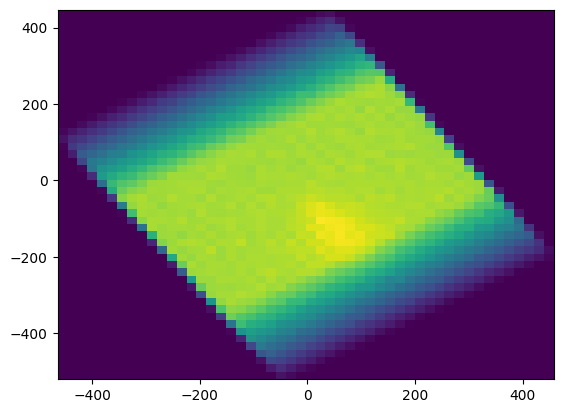

In [25]:
#plt.hist2d(star_coord[:,0][::100], star_coord[:,1][::100], bins=50, cmap='viridis')
plt.hist2d(LMC_sim_pos[:,0][::100], LMC_sim_pos[:,1][::100], bins=50, cmap='viridis')